# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [75]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [76]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [77]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    
    data = data.sort(['ticker', 'date']).with_columns( # Gets the log returns 
        pl.col('price')
        .log()
        .diff()
        .over('ticker')
        .alias('log_return')
    )
    data = data.with_columns( # sums the log returns the last 230 days
        pl.col('log_return')
        .rolling_sum(window_size=230)
        .over('ticker')
        .alias('Current Momentum')
    )
    data = data.with_columns( # lags 22 days to get the signal
        pl.col("Current Momentum")
        .shift(22)
        .alias("momentum")
    )
    return data.drop("log_return").drop('Current Momentum') # drops the 2 intermediat columns to get the momnetum signal
    pass

momentum = task_compute_momentum(data)

momentum

date,barrid,ticker,price,return,market_cap,momentum
date,str,str,f64,f64,f64,f64
1996-01-02,"""USAFU31""",null,27.0,-2.7027,1.0622e9,null
1996-01-02,"""USACVO1""",null,100.25,3.6176,8.7380e9,null
1996-01-02,"""USAIRB1""",null,6.625,0.0,2.2184e8,null
1996-01-02,"""USAHCO3""",null,22.5,-1.0989,3.22515e8,null
1996-01-02,"""USAVYL1""",null,18.125,3.5714,1.4756e9,null
…,…,…,…,…,…,…
2013-03-12,"""USA55I1""","""ZZ""",2.21,0.4545,2.3034167e8,0.220842
2013-03-13,"""USA55I1""","""ZZ""",2.21,0.0,2.3034167e8,0.214011
2013-03-14,"""USA55I1""","""ZZ""",2.21,0.0,2.3034167e8,0.158748


## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [78]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    momentum = momentum.with_columns(
        pl.col('price')
        .shift(1)
        .alias('price_lag')
    )
    momentum = momentum.filter(~((pl.col('price_lag') < 5) | (pl.col('momentum').is_null())))
    return momentum.drop('price_lag')
    pass

price_filter = task_price_filter(momentum)

price_filter

date,barrid,ticker,price,return,market_cap,momentum
date,str,str,f64,f64,f64,f64
1996-03-29,"""USACVO1""",null,93.875,-0.3979,8.1964e9,-0.013986
1996-03-29,"""USAHCO3""",null,22.01562,-2.4238,3.1658e8,-0.047233
1996-04-01,"""USACVO1""",null,94.75,0.9321,8.2728e9,1.156644
1996-04-01,"""USAHCO3""",null,21.75,-1.2065,3.12765e8,0.168335
1996-04-01,"""USAFU31""",null,26.75,-0.9259,1.0810e9,0.170761
…,…,…,…,…,…,…
2008-10-06,"""USA55I1""","""ZZ""",4.94,-7.8358,4.4945108e8,-0.616105
2009-05-07,"""USA55I1""","""ZZ""",5.03,-2.8958,4.61754e8,-0.645918
2009-05-08,"""USA55I1""","""ZZ""",5.5,9.3439,5.049e8,-0.880265


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [79]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    price_filter = price_filter.with_columns(
        pl.col('momentum')
        .qcut(10, labels=[str(i) for i in range(10)])
        .over('date')
        .alias('bin')
    )
    return price_filter
    pass

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,ticker,price,return,market_cap,momentum,bin
date,str,str,f64,f64,f64,f64,cat
1996-03-29,"""USACVO1""",null,93.875,-0.3979,8.1964e9,-0.013986,"""4"""
1996-03-29,"""USAHCO3""",null,22.01562,-2.4238,3.1658e8,-0.047233,"""3"""
1996-04-01,"""USACVO1""",null,94.75,0.9321,8.2728e9,1.156644,"""9"""
1996-04-01,"""USAHCO3""",null,21.75,-1.2065,3.12765e8,0.168335,"""5"""
1996-04-01,"""USAFU31""",null,26.75,-0.9259,1.0810e9,0.170761,"""5"""
…,…,…,…,…,…,…,…
2008-10-06,"""USA55I1""","""ZZ""",4.94,-7.8358,4.4945108e8,-0.616105,"""1"""
2009-05-07,"""USA55I1""","""ZZ""",5.03,-2.8958,4.61754e8,-0.645918,"""3"""
2009-05-08,"""USA55I1""","""ZZ""",5.5,9.3439,5.049e8,-0.880265,"""2"""


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [80]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    port_ret = momentum_bins.group_by(['date', 'bin']).agg(
        pl.col('return').mean()
    ).sort(['bin', 'date'])
    port_ret = port_ret.pivot(
        index='date', 
        on='bin', 
        values='return'
    )
    port_ret = port_ret.with_columns(
        (pl.col('9') - pl.col('8'))
        .alias('Spread')
    )
    return port_ret
    pass

momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

date,0,1,2,3,4,5,6,7,8,9,Spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-01-02,1.1575895,0.307279,0.508596,0.716271,0.70397,0.737496,0.127854,0.4134005,0.508539,0.773136,0.2645965
1996-01-03,-0.326363,-0.054682,-0.302132,-0.033115,-0.369195,-0.183151,-0.234392,-0.172766,-0.484909,-0.710938,-0.226029
1996-01-04,-1.196635,-0.960699,-1.268866,-0.975795,-0.768106,-0.769935,-1.037316,-1.468346,-1.150563,-1.595093,-0.444531
1996-01-05,0.468547,0.561745,0.256527,0.400132,0.230853,0.337011,0.479545,0.794973,0.214222,0.215053,0.000831
1996-01-08,0.118318,-0.086171,0.162793,0.000403,-0.117609,0.30299,-0.250755,0.002269,0.084441,0.102862,0.018422
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,0.843341,0.884776,0.826736,0.776063,0.739306,0.712104,0.877082,0.84689,1.256291,1.251911,-0.004379
2024-12-26,1.563552,0.697287,0.615287,0.547634,0.497044,0.53922,0.371811,0.467918,0.730603,1.42531,0.694707
2024-12-27,-1.318007,-1.221293,-1.03408,-1.063743,-1.163456,-1.175876,-1.228738,-1.291401,-1.524368,-2.127214,-0.602846


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [81]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    df = momentum_portfolios.unpivot(
        index='date',
        variable_name='bin',
        value_name='return')
    df = df.with_columns(
        (pl.col('return') / 100)
        .log1p()
        .alias('log return')
    )
    df = df.with_columns(
        pl.col('log return')
        .cum_sum()
        .over('bin')
        .alias("cumulative_log_return")
    )
    return df.drop('log return')
    pass

momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

date,bin,return,cumulative_log_return
date,str,f64,f64
1996-01-02,"""0""",1.1575895,0.011509
1996-01-03,"""0""",-0.326363,0.00824
1996-01-04,"""0""",-1.196635,-0.003798
1996-01-05,"""0""",0.468547,0.000876
1996-01-08,"""0""",0.118318,0.002059
…,…,…,…
2024-12-24,"""Spread""",-0.004379,0.668741
2024-12-26,"""Spread""",0.694707,0.675664
2024-12-27,"""Spread""",-0.602846,0.669617


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

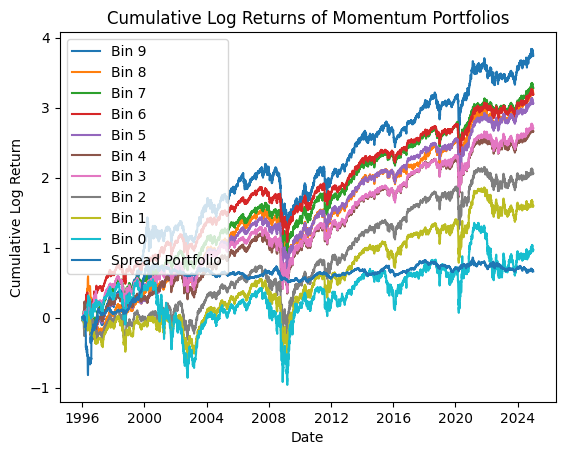

In [82]:
for i in range(10):
    binidf = momentum_returns.filter(pl.col('bin') == str(9-i) )
    plt.plot(binidf['date'], binidf['cumulative_log_return'], label=f'Bin {9-i}')
binidf = momentum_returns.filter(pl.col('bin') == "Spread" )
plt.plot(binidf['date'], binidf['cumulative_log_return'], label=f'Spread Portfolio')
plt.xlabel("Date")
plt.ylabel('Cumulative Log Return')
plt.title("Cumulative Log Returns of Momentum Portfolios")
plt.legend()
plt.show()

In [85]:
table = momentum_returns.group_by('bin').agg(
    (pl.col('return').mean() * 252)
    .alias('Mean Return (Annualized)'),
    (pl.col('return').std() * np.sqrt(252))
    .alias("Volatility (Annualized)")
)
table = table.with_columns(
    (pl.col('Mean Return (Annualized)') / pl.col("Volatility (Annualized)"))
    .alias("Sharpe Ratio")
).sort('bin')

table

bin,Mean Return (Annualized),Volatility (Annualized),Sharpe Ratio
str,f64,f64,f64
"""0""",8.343632,31.671269,0.263445
"""1""",8.987336,26.360733,0.340936
"""2""",10.02529,24.098168,0.416019
"""3""",11.838374,22.318821,0.530421
"""4""",11.504756,21.537671,0.534169
…,…,…,…
"""6""",13.363852,21.504173,0.621454
"""7""",13.521267,20.864495,0.648051
"""8""",13.515001,22.052667,0.612851
